In [1]:
from bowl import load_raw_data

data = load_raw_data()

train_labels.csv
test.csv
specs.csv
train.csv
sample_submission.csv


In [2]:
labels = data['train_labels.csv']

labels.loc[:, 'correct_ratio'] = labels.loc[:, 'num_correct'] / (labels.loc[:, 'num_incorrect'] + labels.loc[:, 'num_correct'])
labels.loc[:, 'correct_diff'] = labels.loc[:, 'num_correct'] - (labels.loc[:, 'num_incorrect'] + labels.loc[:, 'num_correct'])

## Are some games harder?

In [3]:
#  most common accuracy group
labels.loc[:, 'accuracy_group'].value_counts()

3    8845
0    4229
1    2411
2    2205
Name: accuracy_group, dtype: int64

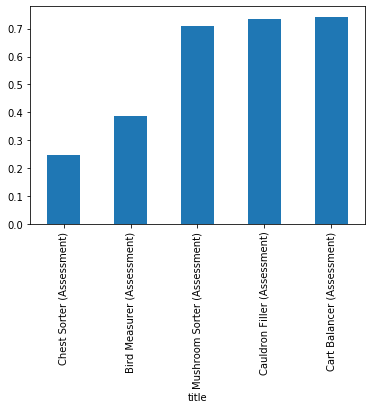

In [4]:
#  avg. accuracy per game
labels.groupby('title').mean().loc[:, 'accuracy'].sort_values().plot(kind='bar')

## Average accuracy per game

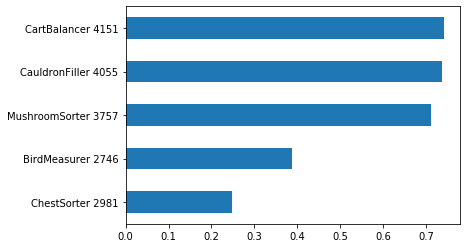

In [5]:
num_played = labels.groupby('title').count().loc[:, 'game_session']
new_cols = []
for name, value in zip(num_played.index, num_played.values):
    new_name = ''.join(name.split(' ')[:2] +  [' ' + str(value)])
    new_cols.append(new_name)
    
num_played.index = new_cols

grp = labels.groupby('title').mean()

grp.index = new_cols

grp.loc[:, 'accuracy'].sort_values().plot(kind='barh')

## matplotlib API

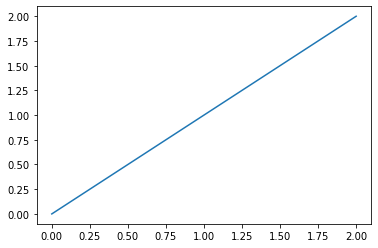

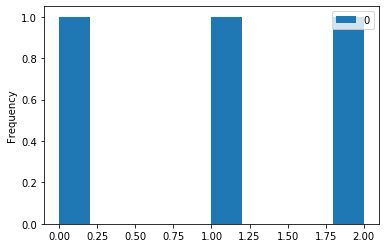

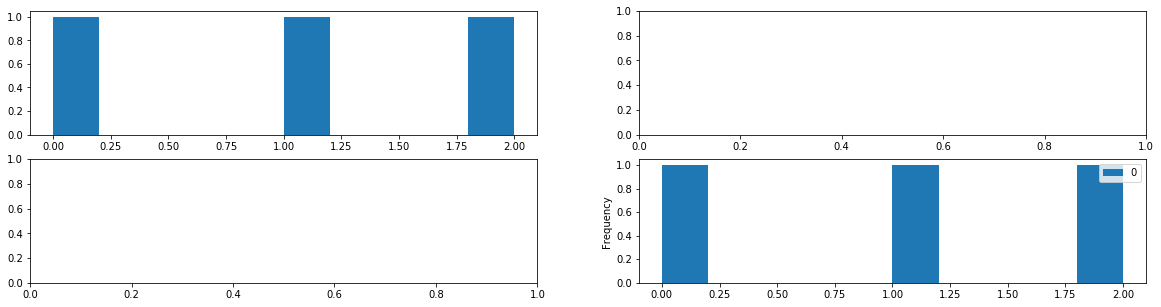

In [6]:
import matplotlib.pyplot as plt

#  classic API
plt.plot(np.array([0, 1, 2]))

#  with pandas
df = pd.DataFrame(np.array([0, 1, 2]))
df.plot(kind='hist')

#  fig, ax
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(20, 5))
axes[0, 0].hist(np.array([0, 1, 2]))
df.plot(ax=axes[1, 1], kind='hist')
fig.savefig('fig.png')

## Are some users better than others?

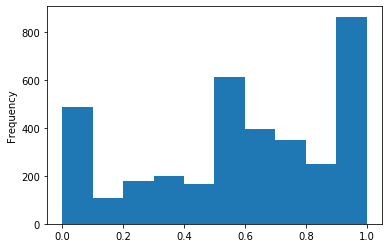

In [7]:
labels.groupby('installation_id').mean().loc[:, 'accuracy'].plot(kind='hist')

In [43]:
axes.shape

#for ax in axes:
    #print(ax.shape)
    
for ax, game in zip(axes, games):
    print(ax, game)
    ax[0]
    ax[1]

 <matplotlib.axes._subplots.AxesSubplot object at 0x124e6ad68>] Chest Sorter (Assessment)
 <matplotlib.axes._subplots.AxesSubplot object at 0x125000c88>] Cauldron Filler (Assessment)
 <matplotlib.axes._subplots.AxesSubplot object at 0x125098b00>] Cart Balancer (Assessment)
 <matplotlib.axes._subplots.AxesSubplot object at 0x1251020b8>] Mushroom Sorter (Assessment)
 <matplotlib.axes._subplots.AxesSubplot object at 0x125161940>] Bird Measurer (Assessment)


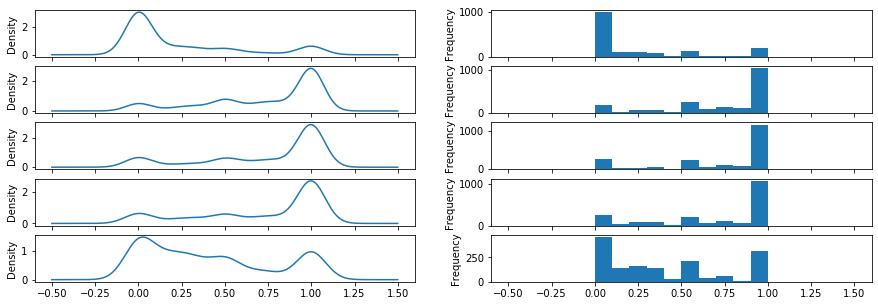

In [36]:
games = set(labels.loc[:, 'title'])
f, axes = plt.subplots(nrows=len(games), ncols=2, figsize=(15, 5), sharex=True)

for row_idx, game in enumerate(games):
    subset_mask = labels.loc[:, 'title'] == game
    subset = labels.loc[subset_mask, :]
    
    ax = axes[row_idx, :]
    
    subset.groupby('installation_id').mean().loc[:, 'accuracy'].plot(kind='kde', ax=ax[0])
    subset.groupby('installation_id').mean().loc[:, 'accuracy'].plot(kind='hist', ax=ax[1])

In [9]:
labels.head()

,game_session,installation_id,title,num_correct,num_incorrect,accuracy,accuracy_group,correct_ratio,correct_diff
0,6bdf9623adc94d89,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3,1.0,0
1,77b8ee947eb84b4e,0006a69f,Bird Measurer (Assessment),0,11,0.0,0,0.0,-11
2,901acc108f55a5a1,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3,1.0,0
3,9501794defd84e4d,0006a69f,Mushroom Sorter (Assessment),1,1,0.5,2,0.5,-1
4,a9ef3ecb3d1acc6a,0006a69f,Bird Measurer (Assessment),1,0,1.0,3,1.0,0


## Baseline predictions

For a given user, predict their accuracy_label

In [26]:
from random import choice

user = choice(labels.loc[:, 'installation_id'])
user

'b2140cf6'

In [32]:
user_mask = labels.loc[:, 'installation_id'] == user
sub = labels.loc[user_mask, :]
sub.loc[:, 'accuracy_group'].value_counts()

3    7
0    3
1    1
Name: accuracy_group, dtype: int64

For a given game, predict the accuracy_label

In [34]:
title = choice(labels.loc[:, 'title'])

game_mask = labels.loc[:, 'title'] == title
sub = labels.loc[game_mask, :]
sub.loc[:, 'accuracy_group'].value_counts()

3    2752
0     576
2     470
1     353
Name: accuracy_group, dtype: int64

For a given user and game, predict accuracy label:

In [86]:
def baseline(installation_id, title, **kwargs):
    user_mask = labels.loc[:, 'installation_id'] == installation_id
    sub = labels.loc[user_mask, :]
    game_mask = sub.loc[:, 'title'] == title
    sub = sub.loc[game_mask, :]
    res = sub.loc[:, 'accuracy_group'].value_counts().idxmax()
    return {'prediction': res, 'installation_id': installation_id, 'title': title}

baseline(user, title)

{'prediction': 3,
 'installation_id': 'b2140cf6',
 'title': 'Cart Balancer (Assessment)'}

In [137]:
preds = []
nrows = labels.shape[0]
#nrows = 100

for row_idx in range(nrows):
    row = labels.loc[row_idx, :]
    row = row.to_dict()
    res = baseline(**row)
    preds.append(res)
    
    if row_idx % 1000 == 0:
        print('row {} of {}'.format(row_idx, nrows))
    
preds = pd.DataFrame(preds, index=np.arange(len(preds)))
preds.set_index(['installation_id', 'title'], inplace=True)
output = labels.join(preds, on=['installation_id', 'title'])

row 0 of 17690
row 1000 of 17690
row 2000 of 17690
row 3000 of 17690
row 4000 of 17690
row 5000 of 17690
row 6000 of 17690
row 7000 of 17690
row 8000 of 17690
row 9000 of 17690
row 10000 of 17690
row 11000 of 17690
row 12000 of 17690
row 13000 of 17690
row 14000 of 17690
row 15000 of 17690
row 16000 of 17690
row 17000 of 17690


In [142]:
output.loc[:, 'prediction'].isnull().sum()

0

In [145]:
output.head()

,game_session,installation_id,title,num_correct,num_incorrect,accuracy,accuracy_group,correct_ratio,correct_diff,prediction
0,6bdf9623adc94d89,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3,1.0,0,3
0,6bdf9623adc94d89,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3,1.0,0,3
0,6bdf9623adc94d89,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3,1.0,0,3
1,77b8ee947eb84b4e,0006a69f,Bird Measurer (Assessment),0,11,0.0,0,0.0,-11,3
1,77b8ee947eb84b4e,0006a69f,Bird Measurer (Assessment),0,11,0.0,0,0.0,-11,3


In [144]:
!pip install sklearn
from sklearn.metrics import accuracy_score

accuracy_score(output.loc[:, 'accuracy_group'], output.loc[:, 'prediction'])

0.7528966001521447

## Training a model

Installation_id, title -> predict accuracy label

In [ ]:
# label encode, pd get dummies

In [154]:
y_tr.shape

(4423, 2)

In [264]:
features = ['installation_id', 'title']
target = ['accuracy_group']

from sklearn.model_selection import train_test_split
dataset = labels.loc[:, features + target]

y = dataset.loc[:, target]
x = dataset.loc[:, features]

x_tr, x_te, y_tr, y_te = train_test_split(x, y)

assert x_tr.shape[0] == y_tr.shape[0]
assert x_te.shape[1] == x.shape[1]
assert y_te.shape[1] == y.shape[1]

In [265]:
from sklearn.preprocessing import OneHotEncoder

one_hot_enc = OneHotEncoder(sparse=False, handle_unknown='ignore')
title_encoding = one_hot_enc.fit_transform(x_tr.loc[:, 'title'].to_frame())

In [266]:
x_tr.loc[:, 'installation_id'].to_frame().shape

(13267, 1)

In [267]:
from sklearn.preprocessing import LabelEncoder

enc = OneHotEncoder(sparse=False, handle_unknown='ignore')
install_encoding = enc.fit_transform(x_tr.loc[:, 'installation_id'].to_frame())
install_encoding = install_encoding.reshape(install_encoding.shape[0], -1)

In [268]:
install_encoding.shape

(13267, 3312)

In [269]:
title_encoding.shape

(13267, 5)

In [270]:
x_tr = np.concatenate([title_encoding, install_encoding], axis=1)

In [271]:
from sklearn.ensemble import RandomForestClassifier

mdl = RandomForestClassifier(n_jobs=8)

mdl.fit(x_tr, y_tr)

/Users/adam/.pyenv/versions/3.6.8/envs/bowl/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=8,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [273]:
accuracy_score(y_tr, mdl.predict(x_tr))

0.8455566443054194

In [275]:
title_encoding = one_hot_enc.transform(x_te.loc[:, 'title'].to_frame())
install_encoding = enc.transform(x_te.loc[:, 'installation_id'].values.reshape(x_te.shape[0], -1))
install_encoding = install_encoding.reshape(install_encoding.shape[0], -1)

x_te = np.concatenate([title_encoding, install_encoding], axis=1)

accuracy_score(y_te, mdl.predict(x_te))

0.5880624010852362

## After lunch

Difference between groupby & resample for time series data

In [13]:
idx = pd.date_range(start='01-01-2018', end='01-03-2018', freq='30T')

df = pd.DataFrame(np.arange(idx.shape[0]),
    index=idx
)

In [14]:
df.head()

,0
2018-01-01 00:00:00,0
2018-01-01 00:30:00,1
2018-01-01 01:00:00,2
2018-01-01 01:30:00,3
2018-01-01 02:00:00,4


In [15]:
df.resample('1d').count()

,0
2018-01-01,48
2018-01-02,48
2018-01-03,1


In [16]:
df.groupby([df.index.day]).count()

,0
1,48
2,48
3,1


In [17]:
df2 = df.drop(df.index[0:2], axis=0)

In [18]:
df2.head()

,0
2018-01-01 01:00:00,2
2018-01-01 01:30:00,3
2018-01-01 02:00:00,4
2018-01-01 02:30:00,5
2018-01-01 03:00:00,6


In [19]:
df2.groupby([df2.index.hour]).count()

,0
0,3
1,4
2,4
3,4
4,4
5,4
6,4
7,4
8,4
9,4


In [20]:
df2.resample('1h').count()

,0
2018-01-01 01:00:00,2
2018-01-01 02:00:00,2
2018-01-01 03:00:00,2
2018-01-01 04:00:00,2
2018-01-01 05:00:00,2
2018-01-01 06:00:00,2
2018-01-01 07:00:00,2
2018-01-01 08:00:00,2
2018-01-01 09:00:00,2
2018-01-01 10:00:00,2


In [21]:
labels.groupby(['title', 'accuracy_group']).describe()

num_correct                                    num_incorrect                                               accuracy                                                                       correct_ratio                                                                       correct_diff                                              
                                                  count mean  std  min  25%  50%  75%  max         count      mean       std  min  25%  50%  75%   max    count      mean       std       min       25%       50%       75%       max         count      mean       std       min       25%       50%       75%       max        count      mean       std   min  25%  50%  75%  max
title                        accuracy_group                                                                                                                                                                                                                                                                                                                                         
Bird Measurer (Assessment)   0                    886.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0         886.0  5.962754  6.597874  1.0  2.0  4.0  8.0  85.0    886.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000         886.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000        886.0 -5.962754  6.597874 -85.0 -8.0 -4.0 -2.0 -1.0
                             1                    778.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0         778.0  4.660668  3.825407  2.0  2.0  3.0  5.0  40.0    778.0  0.226533  0.089452  0.024390  0.166667  0.250000  0.333333  0.333333         778.0  0.226533  0.089452  0.024390  0.166667  0.250000  0.333333  0.333333        778.0 -4.660668  3.825407 -40.0 -5.0 -3.0 -2.0 -2.0
                             2                    389.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0         389.0  1.000000  0.000000  1.0  1.0  1.0  1.0   1.0    389.0  0.500000  0.000000  0.500000  0.500000  0.500000  0.500000  0.500000         389.0  0.500000  0.000000  0.500000  0.500000  0.500000  0.500000  0.500000        389.0 -1.000000  0.000000  -1.0 -1.0 -1.0 -1.0 -1.0
                             3                    693.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0         693.0  0.000000  0.000000  0.0  0.0  0.0  0.0   0.0    693.0  1.000000  0.000000  1.000000  1.000000  1.000000  1.000000  1.000000         693.0  1.000000  0.000000  1.000000  1.000000  1.000000  1.000000  1.000000        693.0  0.000000  0.000000   0.0  0.0  0.0  0.0  0.0
Cart Balancer (Assessment)   0                    576.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0         576.0  2.607639  2.063061  1.0  1.0  2.0  4.0  14.0    576.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000         576.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000        576.0 -2.607639  2.063061 -14.0 -4.0 -2.0 -1.0 -1.0
                             1                    353.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0         353.0  3.257790  2.216635  2.0  2.0  3.0  4.0  26.0    353.0  0.266308  0.074125  0.037037  0.200000  0.250000  0.333333  0.333333         353.0  0.266308  0.074125  0.037037  0.200000  0.250000  0.333333  0.333333        353.0 -3.257790  2.216635 -26.0 -4.0 -3.0 -2.0 -2.0
                             2                    470.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0         470.0  1.000000  0.000000  1.0  1.0  1.0  1.0   1.0    470.0  0.500000  0.000000  0.500000  0.500000  0.500000  0.500000  0.500000         470.0  0.500000  0.000000  0.500000  0.500000  0.500000  0.500000  0.500000        470.0 -1.000000  0.000000  -1.0 -1.0 -1.0 -1.0 -1.0
                             3                   2752.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0        2752.0  0.000000  0.000000  0.0  0.0  0.0  0.0   0.0   2752.0  1.000000  0.000000  1.000000  1.000000  1.000000  1.000000  1.000000        2752.0  1.000000  0.000000  1.000000  1.000000  1.000000  1.000000  1.000000 

In [22]:
labels.groupby('title').sum()

,num_correct,num_incorrect,accuracy,accuracy_group,correct_ratio,correct_diff
title,,,,,,
Bird Measurer (Assessment),1860,9298,1063.742560,3635,1063.742560,-9298
Cart Balancer (Assessment),3575,3122,3081.006889,9549,3081.006889,-3122
Cauldron Filler (Assessment),3634,3834,2982.600942,9354,2982.600942,-3834
Chest Sorter (Assessment),1229,8738,741.152177,2499,741.152177,-8738
Mushroom Sorter (Assessment),3163,3096,2671.384607,8319,2671.384607,-3096


In [23]:
labels.loc[:, 'accuracy_group'].value_counts()

3    8845
0    4229
1    2411
2    2205
Name: accuracy_group, dtype: int64